In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from deepmotion import registration
from deepmotion.simulations import simu3d
from deepmotion.utils import montage, io_utils
import pandas as pd
from os import listdir
from os.path import isdir

In [2]:
# load data
mypath = '/home/cdansereau/data/cobre/cobre_ln_cor/HC/'
listdir(mypath)


def load_subj(source_folder):
    if not isdir(source_folder):
        print 'Error folder does not exist', source_folder
    else: 
        #df = pd.read_csv(source_folder+'motion_params.csv',index_col=0)
        #vol_nii = nib.load(source_folder+'rest_ln.nii.gz')
        dic_data = io_utils.load(source_folder+ 'data_ln.hd5')
        
    #print vol_nii.shape
    #plt.plot(df.values)
    
    return dic_data
    
dic_data = load_subj('/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040123/')

('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])


In [5]:
dic_data.keys()

[u'transfs', u'v2w_affine', u'motion_params', u'vol']

In [3]:
source_path = '/home/cdansereau/data/cobre/cobre_ln_cor/HC/'

m_field       = []
images        = []
motion_params = []
all_v2w       = []

for patientid in listdir(source_path):
    print source_path+patientid
    dic_data = load_subj(source_path+patientid+'/')
    
    # compute motion field
    m_field.append(registration.displacement_field(dic_data['v2w_affine'], 
                                              dic_data['motion_params'], 
                                              dic_data['vol'].shape[:3]))
    # stack images
    images.append(np.swapaxes(dic_data['vol'][np.newaxis,...],0,-1))
    # stack motion params and v2w affine transforms
    motion_params.append(dic_data['motion_params'])
    all_v2w.append(dic_data['v2w_affine'])
    
    
m_field = np.vstack(m_field)[...,:32,:]
images = np.vstack(images)[...,:32,:]
motion_params = np.vstack(motion_params)
all_v2w = np.stack(all_v2w)   
    

/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040033
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040134
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040076
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040127
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040057
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040020
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040115
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdanser

/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040146
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040131
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040017
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040058
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040052
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040128
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040125
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdanser

In [4]:
print images.shape

(11100, 64, 64, 32, 1)


In [18]:
images.shape

(11100, 64, 64, 32, 3)

In [ ]:
# %%
%run models/mocae.py
%run models/fconv_encoder.py

#ccae = inference_mocae()# multi-objective convolutional auto encoder
#ccae = inference_mocae_mul() # same w for encoder end decoder

#ccae = inference_fconv_small12()
ccae = inference_fconv(input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
#ccae = inference_fconv_supercompact()
#ccae = inference_mocae_mul()
#ccae = inference_mocae_multibranch()
#ccae = inference_mocae_concat()
#ccae = inference_2obj()
# %%
learning_rate = 0.000001
#learning_rate = 0.00001
decay=0.
momentum=0.9
epsilon=1e-08
optimizer = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['cost'])
#optimizer_i = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_i'])
#optimizer_m = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_m'])


#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(ccae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# %%
# Fit all training data
hist_train_loss = []
hist_val_loss = []
hist_val_ref_loss = []
batch_size = 3
n_epochs = 20
#mean_data = (images[...,:,np.newaxis]/1000.).mean(0) 
#mean_target = (lr_vols[...,:,np.newaxis]/1000.).mean(0) 
for epoch_i in range(n_epochs):
    for batch_i in range(800 // batch_size):
        #batch_xs, _ = mnist.train.next_batch(batch_size)
        #train = np.array([img - mean_img for img in batch_xs])
        #target = lr_vols[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,np.newaxis]/100.
        train = images[batch_i*batch_size:(batch_i+1)*batch_size,...]/1000.            
        #target -= mean_target
        #train -= mean_data
        motion = m_field[batch_i*batch_size:(batch_i+1)*batch_size,...]

        #print train.shape, motion.shape
        sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.0})
        #sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: target, ccae['keep_prob']: 1.})
        
    # Validation
    #train = lr_vols_motion_cor[0:(799+1)*batch_size,...,:10,np.newaxis]/100.            
    #motion = motion_field[0:(799+1)*batch_size,...,:10,:]

    train_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
    train = images[800:810,...]/1000.  
    #train -= mean_data
    motion = m_field[800:810,...]     
    val_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})

    #target = lr_vols[800:900,...,:10,np.newaxis]/100.
    #target -= mean_target
    #val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: np.zeros_like(motion), ccae['t']: target, ccae['keep_prob']: 1.})
    #val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: target, ccae['keep_prob']: 1.})

    #hist_val_ref_loss.append(val_ref_loss)
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    print('Epoch',epoch_i)
    print('Train loss',train_loss, 'Val loss', val_loss)

# %%
plt.figure()
ax=plt.subplot(111)
plt.plot(range(n_epochs),hist_train_loss,range(n_epochs),hist_val_loss)
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
   ncol=2, mode="expand", borderaxespad=0.)
ax.set_yscale('log')
# Plot example reconstructions
n_examples = 10
test_xs_norm = images[900:910,...]/1000.
motion_test = m_field[900:910,...]

recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
print(recon.shape)
recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})

# Close the Session when we're done.
#sess.close()

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

('Epoch', 0)
('Train loss', 0.086271919, 'Val loss', 0.085912652)


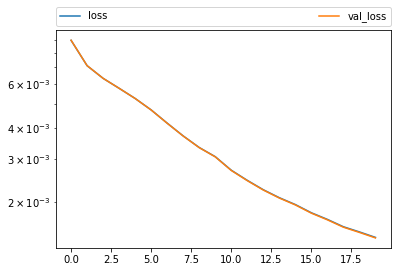

In [20]:

plt.figure()
ax=plt.subplot(111)
plt.plot(range(n_epochs),hist_train_loss,range(n_epochs),hist_val_loss)
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
   ncol=2, mode="expand", borderaxespad=0.)
ax.set_yscale('log')
# Plot example reconstructions
n_examples = 10
test_xs_norm = images[900:950,...]/1000.
motion_test = m_field[900:950,...]

_, recon = batch_loss(test_xs_norm, motion_test)
_, recon_cor = batch_loss(test_xs_norm, np.zeros_like(motion_test))

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

#recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
#print(recon.shape)
#recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})


In [22]:
def compute_corr3D(target, lr_vols_motion_cor, motion_params, motion_field):
    
    #target -= mean_target[np.newaxis,...,0]
    #lr_vols_motion_cor -= mean_data[np.newaxis,...,0]
    
    # create displacement field
    #motion_field = registration.displacement_field(np.eye(4),motion_params, target.shape[1:])%3.

    # compute deepmotion correction
    _, recon = batch_loss(lr_vols_motion_cor, motion_field)
    _, recon_cor = batch_loss(lr_vols_motion_cor, np.zeros_like(motion_field))
    #recon = sess.run(ccae['y'], feed_dict={ccae['x']: lr_vols_motion_cor[...,np.newaxis], ccae['m']: motion_field, ccae['keep_prob']: 1.})
    #recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: lr_vols_motion_cor[...,np.newaxis], ccae['m']: np.zeros_like(motion_field), ccae['keep_prob']: 1.})
    
    results_data = []
    results_data.append(lr_vols_motion_cor)
    results_data.append(recon[...,0])
    results_data.append(recon_cor[...,0])
    
    # regress out the motion  
    cor_map_ref = np.nan_to_num(corrmap3D(target,target))
    mask = (cor_map_ref==1)[0,...]
    residual = mass_univar_reg(ts_vol2vec(lr_vols_motion_cor,mask), simu3d.vexpension(motion_params))
    vol_motion_lincor = ts_vec2vol(residual,mask)
    
    # compute the correlations
    cor_map_ref = np.nan_to_num(corrmap3D(target,target))
    cor_map_lin = np.nan_to_num(corrmap3D(target,results_data[0]))
    cor_map_deep = np.nan_to_num(corrmap3D(target,results_data[1]))
    cor_map_lin_deep = np.nan_to_num(corrmap3D(results_data[0],results_data[1]))
    cor_map_zerom = np.nan_to_num(corrmap3D(target,results_data[2]))
    cor_map_lin_mparam_cor = np.nan_to_num(corrmap3D(target,vol_motion_lincor))
    
    # print the results
    print 'REF:',cor_map_ref[cor_map_ref!=0].mean(),cor_map_ref[cor_map_ref!=0].std()
    print 'cor_map_lin:',cor_map_lin[cor_map_ref!=0].mean(),cor_map_lin[cor_map_ref!=0].std()
    print 'cor_map_deep:',cor_map_deep[cor_map_ref!=0].mean(),cor_map_deep[cor_map_ref!=0].std()
    print 'cor_map_lin_deep:',cor_map_lin_deep[cor_map_ref!=0].mean(),cor_map_lin_deep[cor_map_ref!=0].std()
    print 'cor_map_zerom:',cor_map_zerom[cor_map_ref!=0].mean(),cor_map_zerom[cor_map_ref!=0].std()
    print 'cor_map_lin_mparam_cor:', cor_map_lin_mparam_cor[cor_map_ref!=0].mean(),cor_map_lin_mparam_cor[cor_map_ref!=0].std()
    
    return {'cor_map_ref':cor_map_ref, 
            'cor_map_lin':cor_map_lin, 
            'cor_map_deep':cor_map_deep, 
            'cor_map_lin_deep':cor_map_lin_deep, 
            'cor_map_zerom':cor_map_zerom, 
            'cor_map_lin_mparam_cor':cor_map_lin_mparam_cor,
            'vol_motion':results_data[0],
            'vol_motion_deep':results_data[1],
            'vol_motion_deepcor':results_data[2],
            'vol_motion_lincor':vol_motion_lincor,
            'target':target}
    


In [ ]:
compute_corr3D[results_data[0],results_data[1],results_data[2],motion_params[900:950,:], m_field[900:950,...]]

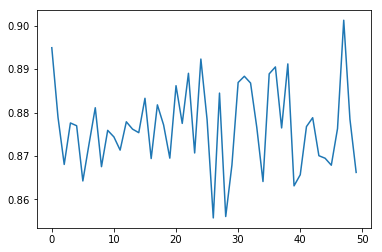

In [36]:
plt.plot(results_data[0][:,25,20,15])

(-0.0025, 0.005)

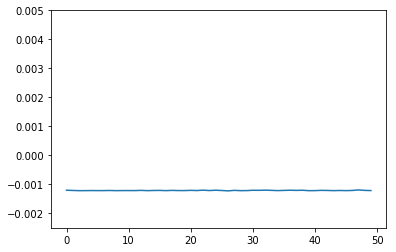

In [43]:
plt.plot(results_data[2][:,25,20,15])
plt.ylim([-0.0025,0.005])

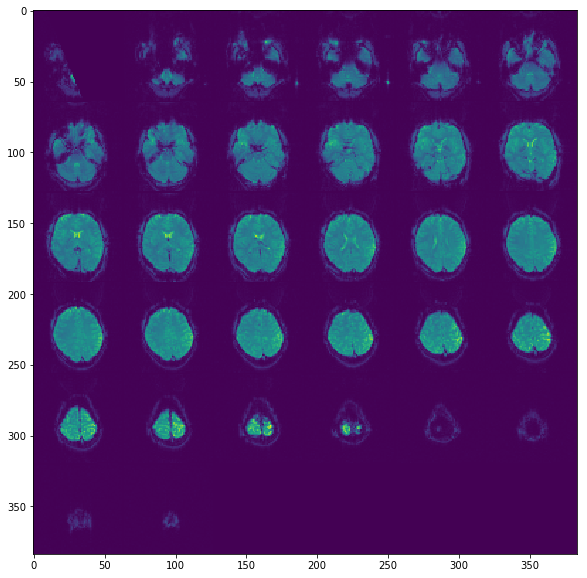

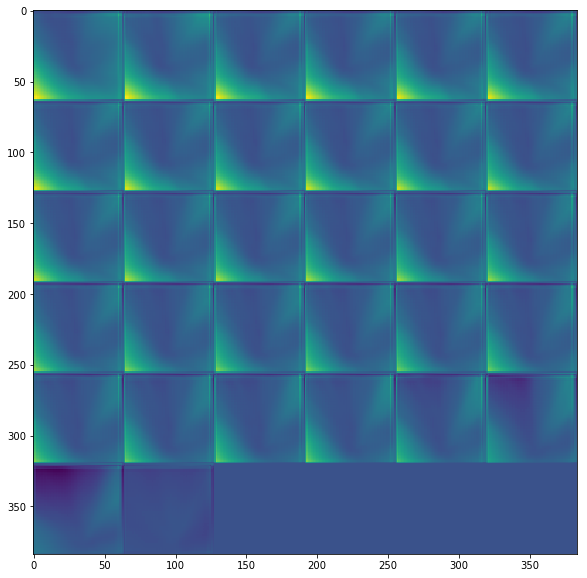

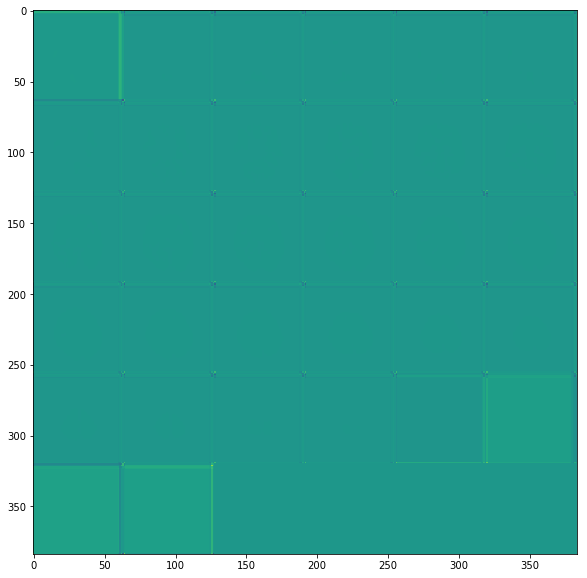

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(results_data[0][0,...,0]))
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(results_data[1][0,...,0]))
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(results_data[2][0,...,0]))

In [17]:
def batch_loss(images, m_field, batch_size=10):
    stack_loss = []
    stack_y_hat = []
    for batch_i in range(images.shape[0] // batch_size):
        train = images[batch_i*batch_size:(batch_i+1)*batch_size,...]/1000.            
        motion = m_field[batch_i*batch_size:(batch_i+1)*batch_size,...]

        #print train.shape, motion.shape
        val_loss, y_hat = sess.run([ccae['cost'], ccae['y']], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
        stack_loss.append(val_loss)
        stack_y_hat.append(y_hat)
        
    return np.vstack(stack_loss), np.vstack(stack_y_hat)


In [ ]:
res_stats = compute_corr3D(sim_s1['lr_vols'][...,:10]/100.,
              sim_s1['lr_vols_motion_cor'][...,:10]/100.,
              sim_s1['motion_params'])

plt.figure(figsize=(9,3))
plt.subplot(1,4,1)
plt.imshow(res_stats['target'][10,:,:,5],interpolation='None')
plt.subplot(1,4,2)
plt.imshow(res_stats['vol_motion'][10,:,:,5],interpolation='None',vmin=0, vmax=1)
plt.subplot(1,4,3)
plt.imshow(res_stats['vol_motion_deep'][10,:,:,5],interpolation='None',vmin=0, vmax=1)
plt.subplot(1,4,4)
plt.imshow(res_stats['vol_motion_deepcor'][10,:,:,5],interpolation='None',vmin=0, vmax=1)


In [12]:
sess.close()